In [195]:
%matplotlib inline
%load_ext line_profiler
import numpy as np
import pandas as pd
import math
import scipy
import scipy.stats as ss
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.animation as animation
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import rc
from matplotlib.patches import Rectangle
import seaborn.apionly as sns
from IPython.display import HTML
import os, glob, sys
import warnings
warnings.simplefilter('always')

from bokeh.server.server import Server
from bokeh.application import Application
from bokeh.application.handlers.function import FunctionHandler
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.sources import ColumnDataSource
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.models import HoverTool
from bokeh.plotting import figure 
output_notebook()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Loading BokehJS ...

In [196]:
np.seterr(all='raise', divide='ignore', over='raise', under='ignore', invalid='raise')

{'divide': 'ignore', 'invalid': 'raise', 'over': 'raise', 'under': 'ignore'}

#### Load Generated Synthetic Data

In [197]:
data = pd.read_csv('observation_single_particle.csv')
data = data.drop(['Unnamed: 0'],axis=1)

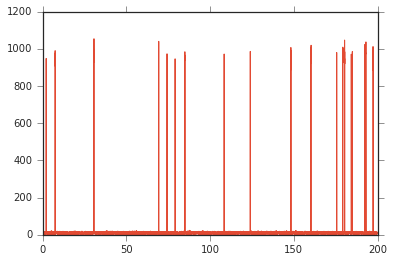

In [198]:
%matplotlib inline
plt.plot(data['0'],data['1'])

N is Number of time levels and is obtained from the length of observations

In [199]:
Wn = np.array(data['1'])
N = len(Wn)  

In [200]:
# ffbs = FFBS()
# A = np.zeros([4,N], dtype=np.float64)
# # Likelihood or Emission distribution
# ID = 0
# p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
# pi0 = np.array([p1,0,0,0,1-p1,0,0,0]) 
# Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) #Snm[8,2]
# F = ffbs.emission_distribution(Wn,Sn,params,M,ID,Snm)      # F[8,N]
# pi_filter = update_pi_filter(pi)

In [201]:
class FFBS:
    def emission_distribution(self,x,Sn,params,M,ID,Snm):
        # This is needed for the calculation of the Filter
        ind = list(range(M))
        ind.remove(ID)
        self.Ksn = np.where(Sn==1,params['k_sigma2'],0.0) # Ksn[M,N]
        self.Ksn_filter = [0.0,params['k_sigma2'],0.0,0.0,0.0,params['k_sigma2'],0.0,0.0] # Ksn_filter[8]
        #self.rate [8,N]
        r = params['theta']*hyper_param['dt']*(params['rho']+np.dot(params['bm'][0,ind],self.Ksn[ind,:]))
        self.rate = [r+params['theta']*hyper_param['dt']*self.Ksn_filter[i] for i in range(2)]   
        likelihood = [-self.rate[0]+x*np.log(self.rate[0]),-self.rate[1]+x*np.log(self.rate[1])]
        
        d = []
        d.append(likelihood)
        for i in range(6):
            d.append(likelihood[0])         
        
        return np.vstack(d)
    
    def get_filter(self,A,pi0,pi_filter,N,F):
        A[:,0] = np.log(pi0)
        #=============================================================================================
        for i in range(1,2):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1])),(A[2,i-1]+np.log(pi_filter[2,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,2])),(A[2,i-1]+np.log(pi_filter[2,2]))])
            A[2,i] = F[2,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            A[3,i] = F[3,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5])),(A[6,i-1]+np.log(pi_filter[6,5]))])
            A[5,i] = F[5,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,6])),(A[6,i-1]+np.log(pi_filter[6,6]))])
            A[6,i] = F[6,i]+np.log(np.sum(np.exp(MM)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            A[7,i] = F[7,i]+np.log(np.sum(np.exp(MM)))
        #=============================================================================================
        for i in range(2,N):
            A[0,i] = F[0,i]+A[0,i-1]+np.log(pi_filter[0,0])
            #-------------------------------------------------------------------------------------
            MM = np.array([(A[0,i-1]+np.log(pi_filter[0,1])),(A[1,i-1]+np.log(pi_filter[1,1])),(A[2,i-1]+np.log(pi_filter[2,1]))])
            Max = -np.max(MM)
            A[1,i] = F[1,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,2])),(A[2,i-1]+np.log(pi_filter[2,2]))])
            Max = -np.max(MM)
            A[2,i] = F[2,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[1,i-1]+np.log(pi_filter[1,3])),(A[3,i-1]+np.log(pi_filter[3,3]))])
            Max = -np.max(MM)
            A[3,i] = F[3,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------                
            A[4,i] = F[4,i]+A[4,i-1]+np.log(pi_filter[4,4])
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[4,i-1]+np.log(pi_filter[4,5])),(A[5,i-1]+np.log(pi_filter[5,5])),(A[6,i-1]+np.log(pi_filter[6,5]))])
            Max = -np.max(MM)
            A[5,i] = F[5,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,6])),(A[6,i-1]+np.log(pi_filter[6,6]))])
            Max = -np.max(MM)
            A[6,i] = F[6,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
            #--------------------------------------------------------------------------------------
            MM = np.array([(A[5,i-1]+np.log(pi_filter[5,7])),(A[7,i-1]+np.log(pi_filter[7,7]))])
            Max = -np.max(MM)
            A[7,i] = F[7,i]-Max+np.log1p(np.sum(np.exp(np.delete(MM,np.argmax(MM))+Max)))
        
        return A
    
    # Filter changes for each particle because of the change in the rates. But transition matrix is the same.
    def Filter(self,pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param):  
        A = np.zeros([8,N], dtype=np.float64)
        # Likelihood or Emission distribution
        F = self.emission_distribution(Wn,Sn,params,M,ID,Snm)      # F[8,N]
        
        p1 = hyper_param['gama']/(hyper_param['gama']+M-1)
        pi0 = np.array([p1,0,0,0,1-p1,0,0,0])   # pi0[8,1] 
#         A_star = pi0*F[:,0]
#         c1 = np.sum(A_star)
#         A[:,0] = A_star[:]/c1  # Array of 8*N where 8 is the number of possible states for the filter 
    
        return self.get_filter(A,pi0,pi_filter,N,F)
    
    def _FFBS(self,N,pi,pi_filter,params):
        # States of the system considered for the filter
        Snm = np.column_stack([[1,1,1,1,0,0,0,0],[0,1,2,3,0,1,2,3]]) #Snm[8,2]
        bm = np.zeros([1,M],dtype=int) 
        for ID in range(M):      
            A = self.Filter(pi,pi_filter,N,ID,Sn,Snm,Wn,M,params,hyper_param) # A[8,N]
            # Sanity Check
            if np.sum(A,axis=0).all()==1:
                pass
            else:
                raise Exception('Filter is not working for ID{} with {}'.format(ID,np.sum(A,axis=0)))        
            
            # Sampling via Gumbel distribution
            g_i = -np.log(-np.log(np.random.uniform(size=8)))
            ind_N = np.argmax(g_i+A[:,N-1])          # Get the state at the last time level
            # Backward Sampling
            Sn[ID,N-1] = Snm[ind_N,1]
            bm[0,ID] = Snm[ind_N,0]
            AA = A[:4,:] if ind_N<4 else A[4:,:]     # AA[4,N]           
            for n in range(N-2,-1,-1):
                weight = AA[:,n]+np.log(pi[:,Sn[ID,n+1]])
                g_i = -np.log(-np.log(np.random.uniform(size=4)))
                Sn[ID,n] = np.argmax(g_i+weight) 
          
        return bm, Sn

In [202]:
class Metropolis_Hastings:
    def __init__(self,alfa1,alfa2):
        self.alfa1 = alfa1
        self.alfa2 = alfa2
        
    def _proposal(self,x,alfa):
        return np.random.gamma(alfa,scale=x/alfa) 
    
    def sample(self,rho_old,k_sigma2_old):
        rho_prop = self._proposal(rho_old,self.alfa1) 
        k_sigma2_prop = self._proposal(k_sigma2_old,self.alfa2)
        return rho_prop, k_sigma2_prop
    
    def _proposal_pdf(self,x1,x2,alfa):
        return ((2*alfa-1)*(np.log(x1)-np.log(x2))+alfa*(x2/x1-x1/x2))
    
    def _prior(self,x1,x2,alfa,beta):
        return (alfa-1)*(np.log(x2)-np.log(x1))+(x1-x2)/beta
    
    def _likelihood(self,x1,y1,x2,y2,Sn,params,hyper_param,Wn):
        Ksn1 = np.where(Sn==1,y1,0.0)
        rate1 = params['theta']*(x1+np.dot(params['bm'],Ksn1))*hyper_param['dt'] 
        
        Ksn2 = np.where(Sn==1,y2,0.0)
        rate2 = params['theta']*(x2+np.dot(params['bm'],Ksn2))*hyper_param['dt'] 

        return np.sum(Wn*(np.log(rate1)-np.log(rate2))+(rate2-rate1))
    
    def Acceptance_ratio(self,params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn):        
        # Calculated the log of Prior_ratio, Proposal_ratio, and Likelihood_ratio
        prior_ratio = (self._prior(rho_old,rho_prop,hyper_param['alfa1_prior'],hyper_param['beta1'])+
                       self._prior(k_sigma2_old,k_sigma2_prop,hyper_param['alfa2_prior'],hyper_param['beta2']))         
        
        proposal_ratio = (self._proposal_pdf(rho_old,rho_prop,self.alfa1)+
                          self._proposal_pdf(k_sigma2_old,k_sigma2_prop,self.alfa2))
        
        likelihood_ratio = self._likelihood(rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Sn,params,hyper_param,Wn) 
        
        return likelihood_ratio+prior_ratio+proposal_ratio

In [203]:
class Gibbs_sampler:  
    def update_theta(self,alfa,beta,Wn,Ksn,params):
        alfa_new = alfa+np.sum(Wn)
        beta_new = beta+np.sum((params['rho']+np.dot(params['bm'][0,:],Ksn))*hyper_param['dt'])
        
        return np.random.gamma(alfa_new,1./beta_new)
    
    def update_roh_ksigma2(self,params,repeats,accepted):
        MH = Metropolis_Hastings(hyper_param['alfa1_proposal'],hyper_param['alfa2_proposal'])
        rho_old = params['rho']
        k_sigma2_old = params['k_sigma2']
        
        # Step (a)
        rho_prop,k_sigma2_prop = MH.sample(rho_old,k_sigma2_old)
        # Step (b)
        AR = MH.Acceptance_ratio(params,hyper_param,rho_prop,k_sigma2_prop,rho_old,k_sigma2_old,Wn)
        # Step (c)
        v = np.random.exponential(scale=1)
        # Step (d)
        if v>-AR:
            accepted = accepted + 1.0
            return rho_prop, k_sigma2_prop, accepted
        else:
            return rho_old, k_sigma2_old, accepted 
            
    def update_pi(self,Sn,M):
        # total number of transitions for all particles over time 
        # is M*(N-1)
        count = dict({0:{0:0,1:0,2:0,3:0},1:{0:0,1:0,2:0,3:0},
                      2:{0:0,1:0,2:0,3:0},3:{0:0,1:0,2:0,3:0}})
        for j in range(M):
            for i in range(N-1):
                state1 = Sn[j,i]
                if Sn[j,i+1]==0:
                    count[state1][0] += 1
                elif Sn[j,i+1]==1:
                    count[state1][1] += 1
                elif Sn[j,i+1]==2:
                    count[state1][2] += 1
                elif Sn[j,i+1]==3:
                    count[state1][3] += 1
                    
        if count[0][1]>M:
            raise Exception('Wrong transitions are happening')
            
        return count

    def update_weight_State(self,hyper_param,pi,pi_filter,params):
        ffbs = FFBS()
        return ffbs._FFBS(N,pi,pi_filter,params)

In [204]:
def update_pi_filter(pi):
    aa = np.zeros([4,4],dtype=np.float64)
    d1 = np.column_stack([pi,aa])
    d2 = np.column_stack([aa,pi])
    return np.vstack([d1,d2])

In [205]:
def __main__(repeats,M,pi,Sn,Ksn,handle):
    data1 = 'Wn_single.h5'
    data2 = 'params_single.h5'
    data3 = 'trajectory_single.h5'
    
    data = dict({'theta': [],'rho': [],'k_sigma2': [],'B':[], 'ite':[],'E_b':[],'E_ph':[]})

    gibbs = Gibbs_sampler()
    accepted  = 0.0
    p = pd.DataFrame()
    for j in range(repeats):
        print(j)
        start1 =  time.time()
        params['theta'] = gibbs.update_theta(hyper_param['alfa'],hyper_param['beta'],Wn,Ksn,params)
        # Metropolis Hastings
        params['rho'], params['k_sigma2'], accepted = gibbs.update_roh_ksigma2(params,repeats,accepted)
        # Update Transition Probabilities
        count = gibbs.update_pi(Sn,M)

        state = 0 
        pi[0] = np.array(list(np.random.dirichlet((0.7+count[state][0],0.3+count[state][1])))+[0,0])
        state = 1
        pi[1] = np.array([0]+list(np.random.dirichlet((0.25+count[state][1],0.25+count[state][2],0.2+count[state][3]))))
        state = 2 
        pi[2] = np.array([0]+list(np.random.dirichlet((0.4+count[state][1],0.6+count[state][2])))+[0])
        pi[3] = np.array([0,0,0,1])
        
        pi_filter = update_pi_filter(pi)
        p = pd.concat([p,pd.DataFrame(pi)],axis=0)
        
        # Sanity Check
        if all(np.sum(pi,axis=1))==1 and all(np.sum(pi_filter,axis=1))==1:
            pass
        else:
            raise Exception('probabilities do not sum to 1')      
        print(params['theta']*params['rho'],params['theta']*params['k_sigma2'])
        
        # FFBS
        params['bm'], Sn = gibbs.update_weight_State(hyper_param,pi,pi_filter,params)
        
        # Sanity Check
        if all(Sn[:,0])==0:
            pass
        else:
            raise Exception('The initial state of the particle is not zero')
            
        # Store the Date
        data['theta'].append(params['theta'])
        data['rho'].append(params['rho'])
        data['k_sigma2'].append(params['k_sigma2'])  
        data['E_b'].append(params['theta']*params['rho'])
        data['E_ph'].append(params['theta']*params['k_sigma2'])
        data['B'].append(np.count_nonzero(params['bm']))      
        data['ite'].append(j)
    
        # Timing
        start2 = time.time()
        print(start2-start1,np.count_nonzero(params['bm']),accepted)

        # Save the output
        ## MCMC Chain Parameters
        df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in data.items()]))
        params_data = pd.HDFStore(data2)
        params_data['df{}'.format(j)] = df.loc[j]
        params_data.close()
        ## Emission Distribution
        Ksn = np.where(Sn==1,params['k_sigma2'],0.0)
        estimated_emission = params['theta']*(params['rho']+np.dot(params['bm'],Ksn))*hyper_param['dt']
        estimated_emission_final = pd.DataFrame(dict({'ite':range(N),'est':estimated_emission.reshape(N,)}))
        
        if j%100==0:
            emission_data = pd.HDFStore(data1)
            emission_data['df{}'.format(j)] = pd.DataFrame(estimated_emission)
            emission_data.close()
            ## Trajectory of data
            trajectory_data = pd.HDFStore(data3)
            trajectory_data['df{}'.format(j)] = pd.DataFrame(Sn)
            trajectory_data.close()
            
        # Some postprocessing
#         new_data = dict({'E_b': [params['theta']*params['rho']],'E_ph': [params['theta']*params['k_sigma2']],
#                          'B':[np.count_nonzero(params['bm'])],'ite':[j]})
#         plot_traces(estimated_emission_final,new_data,handle)
    
    # Calculate Acceptance Rate
    Acceptance_rate = accepted/repeats
    print ("Acceptance rate = " + str(Acceptance_rate*100))
    
    return data, Acceptance_rate, p

#### Hyper-parameters:
dt is the exposure time, alfa & beta are hyper-parameters of Theta, alfa1 & beta1 are hyper-parameters of Rho,
alfa2 & beta2 are hyper-parameters of K_sigma2

In [206]:
repeats = 5000

In [207]:
hyper_param = {'alfa':1.0,'beta':1.0,'alfa1_proposal':10000,'beta1':1.0,'alfa1_prior':1.0,'alfa2_prior':1.0,
               'alfa2_proposal':10000,'beta2':1.0,'N_particles':15,'gama':1.0,'dt':0.01*.95} 

In [208]:
M = hyper_param['N_particles']

## Parameters to be calculated by Gibbs Sampler 

In [209]:
# data1 = 'Wn.h5'
# data2 = 'params.h5'
# params_data = pd.HDFStore(data2)
# params = params_data['df{}'.format(15999)] 
# params = dict(params)

In [210]:
# params_data.close()

In [211]:
params = {'theta':1e+5,
          'rho':0.01,
          'k_sigma2':1,
          'bm':np.ones((1,M),dtype=int)}  # bm[1,M]

#### Note: 
The weights for the transition probability distribution are our hyper-parameters and we assume them.

In [212]:
pi0 = np.array(list(np.random.dirichlet((0.7,0.3)))+[0,0])
pi1 = np.array([0]+list(np.random.dirichlet((0.55,0.25,0.2))))
pi2 = np.array([0]+list(np.random.dirichlet((0.4,0.6)))+[0])
pi3 = np.array([0,0,0,1])

In [213]:
pi = np.stack((pi0,pi1,pi2,pi3),axis=0)

In [214]:
pi

array([[0.77746325, 0.22253675, 0.        , 0.        ],
       [0.        , 0.07385096, 0.21358845, 0.71256059],
       [0.        , 0.0899789 , 0.9100211 , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

In [215]:
# pi = np.array([[9.95012479e-01, 4.72285706e-03, 2.40596046e-04, 2.40677016e-05],
#        [0.00000000e+00, 8.95880600e-01, 9.46496180e-02, 9.46978182e-03],
#        [0.00000000e+00, 9.46496180e-04, 9.99048684e-01, 4.82001787e-06],
#        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

#### Note: 
We know that the initial states of all particles is known and they are Inactive at the initial time level 

In [216]:
# data3 = 'trajectory_single_particle.h5'
# trajectory_data = pd.HDFStore(data3)

In [217]:
Sn = np.zeros([M,N],dtype=np.int)
Sn[:,0] = 0

In [218]:
# Note: Always double check to make sure wrong transitions are not happening, like more than one transition   
# from state zero to state one and from state one to state zero.
for i in range(M):
    for j in range(1,N):
        Sn[i,j] = np.random.choice(4,p=pi[Sn[i,j-1]])  #Sn[M,N] 
# Sn = pd.DataFrame(Sn)  # This is not efficient from computation point of view

In [219]:
# Sn = pd.read_csv('trajectory_single_particle.csv').drop('Unnamed: 0',axis=1).values

In [220]:
# Sn

In [221]:
Ksn = np.where(Sn==1,params['k_sigma2'],0.0)   # Ksn[M,N]

In [222]:
def plot_traces(estimated_emission_final,new_data,handle):
    source.stream(new_data)
    source1.stream(estimated_emission_final)
#     doc.add_periodic_callback(__main__)
    push_notebook(handle=handle)

In [223]:
import time
from line_profiler import LineProfiler
if __name__ == '__main__':
    if os.path.isfile('Wn_single.h5'):
        os.remove('Wn_single.h5')
        os.remove('params_single.h5')
        os.remove('trajectory_single.h5')
        
    output_notebook()
    source = ColumnDataSource({'E_b':[],'E_ph':[],'B':[],'ite':[]})
    
    s1 = figure(width=250, plot_height=250, title=None)
    s1.scatter(x='ite', y='B', color="navy", alpha=0.5, source=source)

    s2 = figure(width=250, height=250, title=None)
    s2.scatter(x='ite', y='E_b', color="firebrick", alpha=0.5, source=source)

    s3 = figure(width=350, height=250, title=None)
    s3.scatter(x='ite', y='E_ph', color="olive", alpha=0.5, source=source)
    
    source1 = ColumnDataSource(pd.DataFrame(columns=['ite','est']))
    s4 = figure(width=350, height=250, title=None)
    s4.scatter(x='ite', y='est', color="black", alpha=0.5, source=source1)
    s4.scatter(range(N), Wn, color="blue", alpha=0.5)
    
    pl = gridplot([[s1,s2,s3],[s4]], toolbar_location=None)
    handle = show(pl, notebook_handle=True, new='window', notebook_url='localhost:8888')
    
    out = __main__(repeats,M,pi,Sn,Ksn,handle) 
    # Use line-profiler for optimization
#     lp = LineProfiler()
#     lp.add_function(FFBS._FFBS)
#     lp_wrapper = lp(__main__)
#     lp_wrapper(repeats,M,pi,Sn,Ksn,pl)
#     lp.print_stats(), format='pdf'
#------------------------------------------------------
#     %lprun -f __main__  __main__(repeats,M,pi,Sn,Ksn) 

Loading BokehJS ...

0
1187.7142137117196 118688.52252088618
41.37524628639221 1 1.0
1
796.701346168274 77646.71094181406
39.61167883872986 1 2.0
2
797.8024837839595 77754.02808714524
39.037456035614014 1 2.0
3
797.5089518660936 77725.42039357433
38.882283210754395 1 2.0
4
796.3140884428012 77608.96870777068
39.70072388648987 1 2.0
5
802.0172850280485 77627.02761349575
39.20769429206848 1 3.0
6
809.6400262248557 77267.09779073561
38.97615122795105 1 4.0
7
808.4148274164722 77056.5607257486
39.366663694381714 1 5.0
8
813.390308771794 76308.92609067047
38.28043222427368 1 6.0
9
813.1166797904391 76283.2553474992
39.15876579284668 1 6.0
10
810.6948030882996 76056.04485793322
38.144357204437256 1 6.0
11
813.8336674816088 76350.52017736422
38.46195912361145 1 6.0
12
816.7904630097925 76342.72689669474
38.87439584732056 1 7.0
13
815.6783663367332 76238.78286644586
38.47358512878418 1 7.0
14
821.0922112221007 76115.81682460225
39.051247119903564 1 8.0
15
818.3903223054571 75865.34985018829
39.60684084892273 1 8.0

38.09900450706482 1 61.0
129
910.8589644146623 75793.5273786549
38.40672326087952 1 61.0
130
910.6883331061359 75779.32896895624
38.946382999420166 1 61.0
131
911.6175395589216 75856.64921003759
38.57735323905945 1 61.0
132
909.3388047668964 77363.77185039823
38.88061594963074 1 62.0
133
903.9795830331392 76907.82561195262
38.84814476966858 1 62.0
134
906.1128960116794 77233.22496873958
39.25010013580322 1 63.0
135
909.3451633097865 76957.18694872774
38.93389081954956 1 64.0
136
910.2796933224768 76898.66672324581
39.235233783721924 1 65.0
137
911.5659958253094 77188.19546626683
38.92275881767273 1 66.0
138
907.0117885904747 76802.56125015278
38.732221603393555 1 66.0
139
908.2863342394671 76910.48528322956
38.17319965362549 1 66.0
140
926.6403819247288 77992.36931822349
38.44754195213318 1 67.0
141
913.4135321607174 76879.10750508223
38.72575092315674 1 67.0
142
908.1892089271055 77840.61088880792
39.09911799430847 1 68.0
143
906.2643471110589 77675.63158915887
39.238520860672 1 68.0


880.7347281141865 86616.04790627772
39.50669813156128 1 123.0
255
883.1887497787058 86857.38919925952
38.979095458984375 1 123.0
256
890.8451888933796 87070.14429282224
39.2012243270874 1 124.0
257
885.7134939054671 86568.57855655852
38.51911687850952 1 124.0
258
886.0439041628409 87802.3327301563
39.250426292419434 1 125.0
259
880.3333603809422 87236.44760544329
39.314019203186035 1 125.0
260
882.2803604339273 87429.3851626847
39.2529559135437 1 125.0
261
881.4300239901153 87345.12125316354
39.12622666358948 1 125.0
262
882.3157931349942 87432.89635868074
39.23176693916321 1 125.0
263
880.52313608037 89402.30003610457
38.50548768043518 1 126.0
264
883.3918835872201 88889.11368147876
38.89020586013794 1 127.0
265
874.3624914809102 88707.97805989227
39.50465130805969 1 128.0
266
872.3494260359846 88503.7435838466
39.272051095962524 1 128.0
267
878.6591172065565 88436.50392971889
39.48166632652283 1 129.0
268
877.8524305242325 88925.32131340596
39.45786786079407 1 130.0
269
875.711019663

38.9724485874176 1 185.0
379
906.4745462544664 91650.81371213171
39.12524199485779 1 186.0
380
919.7440788050417 91582.56149143892
39.32658410072327 1 187.0
381
909.45048771515 90557.58784857237
39.60753846168518 1 187.0
382
904.1028857628512 92095.62452062951
39.70007514953613 1 188.0
383
906.5539022443734 92692.89589425603
39.20267701148987 1 189.0
384
906.1611650887902 91700.26284074367
39.31204128265381 1 190.0
385
902.6887181096824 91348.8636493498
39.75077986717224 1 190.0
386
910.3605513996516 92448.80982192184
43.51611924171448 1 191.0
387
903.6468639445135 91767.02235453913
41.30449461936951 1 191.0
388
904.4510556094663 91848.6895161701
41.70455360412598 1 191.0
389
905.5945033374276 91964.8087629686
39.621898889541626 1 191.0
390
899.9670738804017 92812.30912561847
38.752326011657715 1 192.0
391
909.730698802512 93330.31423785418
39.65594220161438 1 193.0
392
925.9340382391754 94199.7567021494
39.30050539970398 1 194.0
393
919.8164107521243 91285.60972433852
39.4301314353942

932.576948040508 93173.79327162413
41.01054048538208 1 243.0
504
932.8519053680421 93201.264267179
40.05421471595764 1 243.0
505
931.2345422918789 93039.6734695293
40.136759519577026 1 243.0
506
934.1349098352914 94584.65593726287
39.755653381347656 1 244.0
507
927.8902751374106 93952.36330144104
39.91816520690918 1 244.0
508
927.4247737523435 93905.22954390632
39.53479337692261 1 244.0
509
929.2064621440353 94085.63216213766
39.0716450214386 1 244.0
510
926.5960249124811 93821.31562199688
39.330782413482666 1 244.0
511
927.5941211566696 93922.37660243438
38.89288258552551 1 244.0
512
928.8105402233342 94045.54358579472
40.354114055633545 1 244.0
513
930.7499403033625 94241.91510275957
39.153324365615845 1 244.0
514
927.6327814840188 93926.29110527785
39.28119897842407 1 244.0
515
927.0974037613223 93872.08210702229
39.90985822677612 1 244.0
516
938.0537955822053 94738.18255711196
39.46583008766174 1 245.0
517
932.6932335837103 95302.18023807327
39.46367812156677 1 246.0
518
936.442606

39.8092999458313 1 284.0
628
951.2118666969216 93973.40020829787
42.80015301704407 1 284.0
629
952.2039938189329 94071.4157633582
39.77036952972412 1 284.0
630
951.0471405593936 94894.32018357202
39.718464374542236 1 285.0
631
950.0352402387249 94793.35400752429
39.156006813049316 1 285.0
632
948.853645199411 94675.45590005297
39.464306116104126 1 285.0
633
945.049372294196 94295.87020367957
39.78808403015137 1 285.0
634
947.510304121992 94541.41897077797
39.06171894073486 1 285.0
635
948.331913959279 94623.39819519331
39.85079884529114 1 285.0
636
953.2119757981602 95160.55613759517
40.323426723480225 1 286.0
637
957.9274449336833 94853.45749814069
40.29635667800903 1 287.0
638
950.8503038785202 94152.68281856073
40.92941355705261 1 287.0
639
958.0170243052343 94855.2999795751
39.97122144699097 1 288.0
640
954.2283329338342 94480.17360139324
38.640738010406494 1 288.0
641
958.7583452361323 94059.8534024654
39.408239126205444 1 289.0
642
956.285449791948 93817.24776141379
40.3152325153

953.5458981093082 97076.31816744774
39.52765941619873 1 336.0
753
950.014035585258 96716.7547622795
40.41562104225159 1 336.0
754
952.9485866988238 97015.50851723141
39.384819984436035 1 336.0
755
953.4564991912071 97067.21685639957
39.11720156669617 1 336.0
756
966.7170619060338 97020.25589570713
40.070393562316895 1 337.0
757
959.2966429732238 96275.5385713898
38.93328046798706 1 337.0
758
955.2693405955193 96928.65941649677
39.93544363975525 1 338.0
759
967.0341136582668 95509.81199738897
39.3543336391449 1 339.0
760
971.7227364635862 95559.58964535347
39.52958822250366 1 340.0
761
966.9879942844553 95634.60080115189
39.639387369155884 1 341.0
762
967.6207102253102 95976.85619636175
39.2080864906311 1 342.0
763
971.1390484717783 95686.94033173118
39.20252299308777 1 343.0
764
967.052439140303 95284.28414786614
39.19008731842041 1 343.0
765
967.9192584606981 95369.69239987656
38.91089963912964 1 343.0
766
978.1016828322132 95354.06551092386
39.35321044921875 1 344.0
767
976.386675339

39.15912413597107 1 388.0
877
966.506382256451 97488.93044562862
39.28337788581848 1 388.0
878
966.5516875467239 96971.76765599697
39.07902193069458 1 389.0
879
984.266827056649 97662.35881909373
39.569875955581665 1 390.0
880
979.4383534362426 97801.00235575825
39.622849464416504 1 391.0
881
984.5827561467786 97428.95173532948
39.23967695236206 1 392.0
882
976.9109172491811 96669.78830593886
38.919323444366455 1 392.0
883
986.7483500878371 96892.09881560068
39.31168270111084 1 393.0
884
975.1600079408137 98241.2487665663
38.627198934555054 1 394.0
885
983.1577829440967 99167.6009324999
39.392863035202026 1 395.0
886
965.9245735033606 97429.34887748641
39.16029191017151 1 395.0
887
970.1138716520937 97851.90836306234
39.74812579154968 1 395.0
888
972.6735041776336 99372.21740289692
39.670936822891235 1 396.0
889
964.4839928971184 98535.54415961895
40.137369871139526 1 396.0
890
963.572053245508 98442.37675562478
39.85004019737244 1 396.0
891
963.0908225792497 98393.2123050841
39.491851

977.8101380701545 97852.43735656553
38.61530923843384 1 449.0
1002
995.3856023171776 98612.43181000407
38.860923767089844 1 450.0
1003
983.9612413631211 97480.62518859807
39.222843647003174 1 450.0
1004
982.4604914764842 97331.9465302818
39.05500316619873 1 450.0
1005
985.314837382823 97614.72537538038
38.56343388557434 1 450.0
1006
984.7852356800408 97562.25795804936
38.773728370666504 1 450.0
1007
977.7171301433851 99345.39995586575
38.64665913581848 1 451.0
1008
971.1236525464963 98823.58580363117
39.400537729263306 1 452.0
1009
970.0296381562797 98712.25659784109
39.500367641448975 1 452.0
1010
974.6829651380403 99185.7889405541
39.36504411697388 1 452.0
1011
974.5852973734225 99175.85006336618
39.22106909751892 1 452.0
1012
971.3564136616195 98847.27206435794
39.21073532104492 1 452.0
1013
982.2298152111711 98081.80994184458
39.753092765808105 1 453.0
1014
993.6749449204142 97086.18075015633
39.27350115776062 1 454.0
1015
992.3069919390038 96952.5260463824
38.77835297584534 1 454.

39.31900143623352 1 495.0
1124
987.3520288685532 98907.49980402332
39.77606678009033 1 496.0
1125
985.5722289597055 99145.48961993639
38.42712950706482 1 497.0
1126
988.4313654887908 98170.61849341058
39.18927025794983 1 498.0
1127
993.2835370244889 98480.770685303
38.56557273864746 1 499.0
1128
990.2674771600674 98181.7383457849
39.273911237716675 1 499.0
1129
988.0635203998512 97963.22333751913
39.421361446380615 1 499.0
1130
989.4807519927596 98103.73715286663
39.57675099372864 1 499.0
1131
986.1630531061649 97774.79830401349
39.8502938747406 1 499.0
1132
989.2601009643796 98081.86033470002
39.127477169036865 1 499.0
1133
989.6816954908729 98123.66003472338
39.45595121383667 1 499.0
1134
992.5904681293454 98911.4938083721
38.856438398361206 1 500.0
1135
984.7858817448359 98133.76792581032
39.60375094413757 1 500.0
1136
988.7162984307878 98464.56295492277
39.285688400268555 1 501.0
1137
989.1542198563828 98508.17479974445
39.333367586135864 1 501.0
1138
984.5818310607385 98052.818429

1005.5068296085855 96893.54517507802
39.22117757797241 1 542.0
1247
991.0529203374083 97592.3450596607
39.812031269073486 1 543.0
1248
997.1084442786977 98188.65305680998
39.45568060874939 1 543.0
1249
994.0653065219283 97888.98495238464
39.64152693748474 1 543.0
1250
996.3401395860134 98112.99548581582
39.33027410507202 1 543.0
1251
995.1878695489896 98509.37135605521
40.174609899520874 1 544.0
1252
989.3983912250801 98930.15706158319
39.9481885433197 1 545.0
1253
986.6360453139392 98653.94950225089
38.91419291496277 1 545.0
1254
987.4488281209906 98735.21982922098
40.34307646751404 1 545.0
1255
995.1178858129704 98859.91368491846
39.08933234214783 1 546.0
1256
990.1176806627444 98363.16866947299
39.43854379653931 1 546.0
1257
982.9749613857202 98368.84532772022
39.50626277923584 1 547.0
1258
988.3522642616007 98906.96592657261
39.235814571380615 1 547.0
1259
988.6848696376829 98940.25060632567
39.435226917266846 1 547.0
1260
988.4351249622338 98915.2580110758
39.38392519950867 1 547.

39.522144079208374 1 590.0
1369
996.8948731312089 98679.83456456753
39.247692346572876 1 590.0
1370
997.1309761253959 98703.20573943714
39.439443826675415 1 590.0
1371
993.4859371774334 98342.39353138898
39.014798641204834 1 590.0
1372
1006.4340835533009 98646.32536011162
39.48058366775513 1 591.0
1373
1000.5629089762843 98070.85816654682
39.78234386444092 1 591.0
1374
999.4235433063433 98989.57938049285
39.834043979644775 1 592.0
1375
995.9608668013948 98646.61278434725
40.15172553062439 1 592.0
1376
992.3591213143011 99400.59665622356
39.12657928466797 1 593.0
1377
989.255545899624 99089.72406850762
39.46486568450928 1 593.0
1378
986.6826484805446 98832.00734771704
39.487847328186035 1 593.0
1379
989.8885814641676 98951.83661806308
39.56480073928833 1 594.0
1380
988.0401084514242 100080.44100739097
38.99758505821228 1 595.0
1381
984.068711437588 99678.17073398769
39.34973764419556 1 595.0
1382
983.5840811937962 99629.0816250443
39.48506546020508 1 595.0
1383
984.2564008361122 99697.1

39.08266305923462 1 642.0
1491
1006.9669974745007 99767.81333703121
39.09491324424744 1 643.0
1492
1006.169878225292 99831.89027330419
38.700145959854126 1 644.0
1493
1003.227678693616 99448.24007022624
39.24999785423279 1 645.0
1494
993.4332813588139 98477.33825184444
39.09625506401062 1 645.0
1495
995.8339042919733 98715.30788809471
39.93753671646118 1 645.0
1496
1000.5984908693893 99187.61318812716
39.017167806625366 1 645.0
1497
996.3283120566481 98764.31768230014
39.39205503463745 1 645.0
1498
995.6328336558931 98695.37610061253
39.640979290008545 1 645.0
1499
995.8922517896182 99292.70007170147
39.36244869232178 1 646.0
1500
994.9151812245782 99226.07405184423
39.98962450027466 1 647.0
1501
995.0549454388105 99240.01318407674
39.48242378234863 1 647.0
1502
993.1912989132569 99054.1457537261
39.272868394851685 1 647.0
1503
1002.917704392463 98938.29508323017
39.6038875579834 1 648.0
1504
1014.4183360080654 99281.64546136287
39.47728681564331 1 649.0
1505
1002.4918422460335 98114.3

39.5574312210083 1 683.0
1613
1000.5152994127905 98038.93600209667
38.85097360610962 1 683.0
1614
1001.9306067829071 98257.57147842024
38.491552114486694 1 684.0
1615
1003.3929804652697 98400.98389206461
38.73690128326416 1 684.0
1616
990.650259289173 98872.09004525894
39.00305104255676 1 685.0
1617
993.500182096347 99156.52728410358
39.85605788230896 1 685.0
1618
994.6209559312849 99268.3863892613
39.41139554977417 1 685.0
1619
1007.1788130415747 99490.75824407478
39.324103593826294 1 686.0
1620
999.7452936279744 98756.46312854535
38.864410638809204 1 686.0
1621
1003.0532790625298 100422.53071383528
39.27480673789978 1 687.0
1622
989.990096477326 99114.68607410773
39.654327154159546 1 687.0
1623
995.816633580627 99698.02059224859
38.924628019332886 1 687.0
1624
995.2966228873433 99645.95876172787
38.842475175857544 1 687.0
1625
992.6409106181005 99380.07722533093
38.81922626495361 1 687.0
1626
990.2508579434453 99140.79268966541
39.24496150016785 1 687.0
1627
996.9847801119641 100665.

995.9126405906071 99054.38081800015
40.15263390541077 1 717.0
1736
1002.9120863390498 100134.9865245024
39.480751752853394 1 718.0
1737
992.5541845575153 99100.8097811528
39.19949960708618 1 718.0
1738
995.3598691921162 99380.94120733126
39.37087321281433 1 718.0
1739
994.5289032641082 99297.97405284502
39.53945970535278 1 718.0
1740
999.6046338119492 99358.2858349915
40.18482995033264 1 719.0
1741
995.191773455323 98919.65817578234
39.65776586532593 1 719.0
1742
993.5296148440357 98754.44362513187
39.33753514289856 1 719.0
1743
996.9954016962673 99098.93446586956
39.11229348182678 1 719.0
1744
999.6302381134666 99360.83084070949
39.07553434371948 1 719.0
1745
1009.2300367534083 100221.00870642971
39.73076844215393 1 720.0
1746
997.2849532868509 99034.80905867451
39.85891151428223 1 720.0
1747
996.6836579824259 98975.09777408594
39.441497802734375 1 720.0
1748
996.4733201676197 99113.09275823961
39.70928239822388 1 721.0
1749
992.9163278962732 98759.30054143345
39.689903259277344 1 721

39.358452558517456 1 749.0
1857
995.6552612841208 99554.80993076798
39.57362389564514 1 749.0
1858
995.6373355056999 99553.01754586033
39.3192138671875 1 749.0
1859
999.5432153374419 99943.56349020656
38.58747959136963 1 749.0
1860
994.8464961331262 99473.9421203754
38.86846709251404 1 749.0
1861
993.685835742916 99357.88857349563
39.28187656402588 1 749.0
1862
996.9581982947093 99685.08960836806
38.76535415649414 1 749.0
1863
995.0224703513112 99491.53764819045
39.61083912849426 1 749.0
1864
996.0995637694052 99599.2353972866
38.549702882766724 1 749.0
1865
996.7773291244497 99667.00463802973
38.65352749824524 1 749.0
1866
995.249140331806 99514.20220660004
39.38414454460144 1 749.0
1867
992.0014544223462 99189.46857036724
40.36372232437134 1 749.0
1868
994.5499429960912 99444.28999846143
39.82181406021118 1 749.0
1869
993.60085525277 99349.39143912263
39.73081922531128 1 749.0
1870
995.0943900863228 99498.7288476224
39.669363498687744 1 749.0
1871
993.5068242764756 99339.98935354482


38.955832958221436 1 772.0
1979
993.5058164881691 99313.02103327964
39.221378326416016 1 772.0
1980
995.0922501637939 99471.60442391559
39.41544485092163 1 772.0
1981
993.7565917740817 99338.08908102647
39.5917706489563 1 772.0
1982
998.0497200502653 99767.2396020554
39.56326603889465 1 772.0
1983
995.270989937504 99489.4716438265
39.548216342926025 1 772.0
1984
997.6463607019517 99726.91891668223
39.1060516834259 1 772.0
1985
997.335360403295 99381.04320661636
39.657289266586304 1 773.0
1986
994.9883118145774 99147.1678759462
39.361899614334106 1 773.0
1987
998.1818939074359 99465.39736279193
39.657469511032104 1 773.0
1988
999.3895878369519 99585.73991491107
39.23087692260742 1 773.0
1989
994.5000265036485 99098.51192178154
39.853676557540894 1 773.0
1990
996.0279159040646 99250.76085282944
39.061073541641235 1 773.0
1991
996.0554557441695 99253.5051033073
37.99122190475464 1 773.0
1992
993.7812595609798 99026.88926462842
39.88191843032837 1 773.0
1993
997.0587297728881 99353.4779144

39.63597750663757 1 796.0
2101
996.589604781008 99367.08202602841
38.47733497619629 1 796.0
2102
996.4651627689175 99354.67427105729
38.75742697715759 1 796.0
2103
998.999946186879 99607.41023238226
39.02085590362549 1 796.0
2104
1002.1778893270279 99249.83499971767
39.43886160850525 1 797.0
2105
998.2133932049812 98857.21449774834
39.07106280326843 1 797.0
2106
997.610458894791 99895.67300908276
38.650986194610596 1 798.0
2107
994.7640346733559 99610.64646316561
38.69315147399902 1 798.0
2108
994.7414641787084 99608.3863678219
38.96471166610718 1 798.0
2109
994.073667050238 99541.51653602807
38.98988890647888 1 798.0
2110
993.0304422905272 99437.05327730632
38.83892202377319 1 798.0
2111
996.4514143262703 99779.61213964464
38.69027352333069 1 798.0
2112
997.6638781185159 99901.02214035744
39.225306272506714 1 798.0
2113
998.123185547828 99947.01486663663
39.18281555175781 1 798.0
2114
995.8941174528467 99723.80724531926
38.793068408966064 1 798.0
2115
1001.4493913743415 99313.74518837

39.07571339607239 1 819.0
2223
1003.3349871930249 99741.08994240979
39.787352323532104 1 820.0
2224
1001.7907790382646 99240.56267407986
39.10697817802429 1 821.0
2225
1000.0535029419963 99068.46260995328
39.343082666397095 1 821.0
2226
1001.0953203572926 98979.92045036993
39.43750190734863 1 822.0
2227
1001.8595750231207 99055.48355059548
38.975159645080566 1 822.0
2228
1000.9998360950967 98970.479766267
39.39207315444946 1 822.0
2229
999.6834353033573 98840.32508169544
39.23311638832092 1 822.0
2230
1000.1507876404372 98886.53296640512
39.335078716278076 1 822.0
2231
1002.4255877836707 99111.44615163245
40.07079887390137 1 822.0
2232
1001.1186916723083 98982.23121024866
38.54508924484253 1 822.0
2233
1000.910838775835 98961.68045674903
38.87676215171814 1 822.0
2234
1000.8994897389221 98960.55835903467
39.2334840297699 1 822.0
2235
1006.0753570214154 99607.13360649464
39.67268991470337 1 823.0
2236
1005.4616548697362 99418.15799381946
39.38076615333557 1 824.0
2237
1001.1885996897789

38.48996639251709 1 843.0
2345
998.1499886826496 99569.28264363788
40.20371770858765 1 843.0
2346
997.1001212306686 99464.55434603742
41.76142191886902 1 843.0
2347
999.0156622958775 99655.6369006633
44.091302156448364 1 843.0
2348
995.0769449863457 99262.73477022923
44.387264013290405 1 843.0
2349
998.2902457529325 99583.27382335246
39.7969925403595 1 843.0
2350
1005.8039774219836 100606.77274465187
40.05579733848572 1 844.0
2351
1002.3806443880085 99502.61342521016
39.83970928192139 1 845.0
2352
994.6634565693786 98616.06300939
40.78945779800415 1 846.0
2353
1001.5912033426827 99302.9155400596
41.0744047164917 1 846.0
2354
1004.8550233933124 99824.60492805726
41.50478172302246 1 847.0
2355
1000.504797417306 99392.4434925338
41.28175330162048 1 847.0
2356
1005.6164104752631 99987.75056293988
41.07814145088196 1 848.0
2357
996.7035766903173 99101.55360750541
41.359885931015015 1 848.0
2358
997.4484126233181 99175.61213390117
42.781689405441284 1 848.0
2359
1001.9851814935658 99626.6999

999.3877402335701 99991.501378542
47.15892457962036 1 862.0
2468
999.4867975815893 100577.545830971
44.41635537147522 1 863.0
2469
993.9051058890465 100015.86472284686
45.39998984336853 1 863.0
2470
995.3054036459203 100156.77555044334
43.89021682739258 1 863.0
2471
1005.8571440002976 99437.48714298324
42.173325061798096 1 864.0
2472
999.4840701817403 98807.45488673884
43.235883951187134 1 864.0
2473
999.7215461475785 99323.08258990543
43.4836847782135 1 865.0
2474
1000.5552230184903 99405.90900994405
43.1795814037323 1 865.0
2475
1002.8806393203306 99636.9408570555
42.25625157356262 1 865.0
2476
997.5136568213605 99103.72713563683
42.88285970687866 1 865.0
2477
998.5742209782027 99209.09497706013
42.89550590515137 1 865.0
2478
998.9933870206851 99250.73943657667
43.06534457206726 1 865.0
2479
998.173165780782 99169.24984353267
42.630491971969604 1 865.0
2480
998.9662905611284 99248.04738307356
43.027766704559326 3 865.0
2481
1000.4202721656836 99392.50154188402
42.23944282531738 3 865

1000.955381092464 99983.80334494694
42.48707294464111 1 883.0
2590
998.4143013355716 99729.97902520587
43.02314305305481 1 883.0
2591
998.3193573974966 99720.49522981138
41.887994050979614 1 883.0
2592
997.8873193444848 99677.3396521045
42.425904273986816 1 883.0
2593
993.6005709222655 99249.1433315366
41.52695083618164 1 883.0
2594
998.0863353092051 99697.21903279916
43.25987195968628 1 883.0
2595
997.409579637492 99629.61901058909
42.87636065483093 1 883.0
2596
998.4982363862167 99738.36316075874
43.32599210739136 1 883.0
2597
997.2151936509987 99610.20211088138
43.28172492980957 1 883.0
2598
998.0123322893369 99689.82699163009
43.55627775192261 1 883.0
2599
997.023231653518 99591.0273394896
42.854055881500244 1 883.0
2600
996.1664438484378 100199.4799487444
42.67876982688904 1 884.0
2601
1003.8581472807261 99123.54587911839
43.244001150131226 1 885.0
2602
1001.1533374619839 98856.46597257118
42.74519443511963 1 885.0
2603
998.0009624532482 100072.36657346852
42.46427273750305 1 886.

42.8351616859436 1 902.0
2711
999.7427214064146 99321.06950408235
42.57907557487488 1 902.0
2712
998.9830777781683 99245.60147017335
42.092331647872925 1 902.0
2713
1000.1792803606172 99364.44016465789
43.051007986068726 1 902.0
2714
999.2746724344046 99274.57041638215
42.46110701560974 1 902.0
2715
998.2450560366525 99172.28149782936
41.98125982284546 1 902.0
2716
999.5119914332436 99298.14725897738
42.65900111198425 1 902.0
2717
1001.4638592477055 99492.05874711528
43.250282764434814 1 902.0
2718
1001.6784649979163 99513.37910501965
42.861672163009644 1 902.0
2719
1000.4946376547479 99395.76984884395
43.08868217468262 1 902.0
2720
1001.1552801790822 99461.40245678579
42.915526151657104 1 902.0
2721
997.4166216576236 99089.97933470548
43.29206204414368 1 902.0
2722
1001.9774159701697 99543.07887642854
42.908344745635986 1 902.0
2723
1005.610624571628 99081.84201360222
42.45604944229126 1 903.0
2724
1004.1954039736211 98942.4016971618
43.39083528518677 1 903.0
2725
998.755686840539 100

43.468512296676636 1 918.0
2833
995.4156983991674 99394.61779856774
42.77945351600647 1 919.0
2834
998.5795875636206 99710.5396338006
42.58292865753174 1 919.0
2835
996.3599381287378 99488.90237453113
43.523611307144165 1 919.0
2836
1002.7921142120276 99973.473778127
42.6683931350708 1 920.0
2837
997.8655920002896 100101.06596223883
42.711710929870605 1 921.0
2838
994.8165037468829 99795.19612683634
43.25600600242615 1 921.0
2839
997.9873106373133 100113.27618915841
42.214242935180664 1 921.0
2840
995.0075422802623 99814.36019160063
41.45126461982727 1 921.0
2841
996.7891670105478 99993.08419619202
42.69734573364258 1 921.0
2842
997.1728990210979 100031.57834170405
43.06294322013855 1 921.0
2843
998.4548380215188 100160.17628261857
41.1765832901001 1 921.0
2844
993.0975891346177 99622.76289898959
42.136292934417725 1 921.0
2845
996.2074630547277 99934.73045945748
42.49222230911255 1 921.0
2846
999.3138142711716 100236.77771915974
42.664438009262085 1 922.0
2847
994.8759406391246 99791.

993.1193252587323 99926.4820947124
42.08551001548767 1 934.0
2955
1008.2104691288554 99657.27773079344
41.985804080963135 1 935.0
2956
1001.1768271288678 98962.03240681124
42.49144172668457 1 935.0
2957
1001.7614722753794 99019.82207030304
42.13466191291809 1 935.0
2958
1000.6925185937455 98914.16058672017
42.72357130050659 1 935.0
2959
1002.7117327642502 99113.75124120108
42.432215452194214 1 935.0
2960
1003.6642767241799 99207.90612341285
42.72802209854126 1 935.0
2961
1004.8455663846248 99324.67153636596
42.32754564285278 1 935.0
2962
1002.3162329062199 99074.65777768222
42.35422348976135 1 935.0
2963
1004.2278938978922 99263.61726204348
43.19686961174011 1 935.0
2964
998.7828941473443 99715.49415477405
43.40894412994385 1 936.0
2965
997.7072360570932 99608.10367117696
42.6365442276001 1 936.0
2966
997.8575093779356 99623.10650966558
42.583136320114136 1 936.0
2967
998.1933419841957 99656.6350317125
42.38821601867676 1 936.0
2968
998.1960653433638 99656.9069237391
42.262211322784424

42.56148838996887 1 948.0
3076
999.2485669913282 98999.0680773652
42.70498466491699 1 948.0
3077
1001.7764538746071 99249.51471688665
42.83902168273926 1 948.0
3078
1002.5066135126704 99533.04141640817
42.343313694000244 1 949.0
3079
999.0919326275985 99881.59014967788
42.637664794921875 1 950.0
3080
995.6362930504579 99536.12166506985
42.38792562484741 1 950.0
3081
998.4431573191004 99816.73054332292
42.202160358428955 1 950.0
3082
997.4224483258067 99714.68784434715
42.38615536689758 1 950.0
3083
998.8210363377624 99854.5080050715
42.350966930389404 1 950.0
3084
995.9199279442008 99564.47731812218
42.35621428489685 1 950.0
3085
996.8085268974604 99653.31266305735
42.29869604110718 1 950.0
3086
995.970924562616 99569.57557101887
42.757511377334595 1 950.0
3087
996.6830647862168 99640.76991822546
42.72663140296936 1 950.0
3088
997.8220225459274 99754.6342268422
42.515185594558716 1 950.0
3089
995.6620961399441 99538.70126112552
41.96642994880676 1 950.0
3090
996.3458344770486 99187.474

42.026440143585205 1 967.0
3198
999.6316836878183 99816.54978714795
42.06310987472534 1 967.0
3199
998.7157547993689 99725.09123997773
41.92344665527344 1 967.0
3200
998.0613110616391 99659.74285517164
42.75807595252991 1 967.0
3201
998.9099278237844 99744.48006255626
43.376814126968384 1 967.0
3202
998.8863031855282 99742.12106381785
42.7674994468689 1 967.0
3203
997.3175385476188 99585.47469482069
42.766477823257446 1 967.0
3204
996.3146736770029 99485.33530056068
42.75260591506958 1 967.0
3205
998.304291328209 99684.00524328033
42.43456411361694 1 967.0
3206
998.2212237485714 99675.71066905475
42.46997880935669 1 967.0
3207
997.4888646276262 99602.58217397922
42.86827254295349 1 967.0
3208
996.7451830558342 99528.32309451237
41.85961365699768 1 967.0
3209
996.9949986376502 99553.26801159217
42.647703886032104 1 967.0
3210
1000.5661056671704 99909.85493097863
42.2592978477478 1 967.0
3211
997.8039686659174 99634.04636067865
43.129316568374634 1 967.0
3212
996.7567861469461 99529.4817

41.46683120727539 1 977.0
3320
1000.003568506101 99814.94942034227
42.211649656295776 1 977.0
3321
1002.3422172549182 99723.68118220798
42.58355188369751 1 978.0
3322
996.5758564561551 99149.98218402322
41.75694012641907 1 978.0
3323
998.4770023839341 99339.12843279833
42.75580191612244 1 978.0
3324
1001.2587252474142 99694.5679847192
42.51520299911499 1 979.0
3325
1001.9779126887847 99766.17692999929
41.7748544216156 1 979.0
3326
1002.0247254224777 99770.83803820642
42.73724937438965 1 979.0
3327
997.812833226822 99351.46314313088
42.04023003578186 1 979.0
3328
1000.1025691591732 99579.45040438388
42.536853551864624 1 979.0
3329
1002.0344683356075 99771.80813263945
42.662851333618164 1 979.0
3330
998.0437097806539 99374.45134559211
42.957191467285156 1 979.0
3331
1003.4616877142363 99530.14242308373
41.71447014808655 1 980.0
3332
999.9406896741069 99180.9059343407
42.37470030784607 1 980.0
3333
999.5791920271098 99145.05014359976
42.5086145401001 1 980.0
3334
1001.3796398898236 99658.

42.00190615653992 1 994.0
3442
1001.4776516179559 99758.50395108311
41.83663892745972 1 994.0
3443
1000.3801905428838 99649.18441228276
42.7282657623291 1 994.0
3444
1000.9003633059914 99700.99950427195
43.179856061935425 1 994.0
3445
1000.969965658008 99707.93268595349
43.164650678634644 1 994.0
3446
1000.0099713951747 99612.30639683244
42.678587436676025 1 994.0
3447
1001.5503534303109 99765.74587407894
42.32870578765869 1 994.0
3448
997.7370804413175 99385.90074431046
42.83909845352173 1 994.0
3449
999.3601238924587 99547.57423375067
43.0384578704834 1 994.0
3450
1002.1771961405934 99828.18649957808
42.673194885253906 1 994.0
3451
998.6858798451257 99702.48240570001
43.345892667770386 1 995.0
3452
993.8067295451892 99215.37889622652
42.89465570449829 1 995.0
3453
999.915472157156 99825.23712600846
42.90625524520874 1 995.0
3454
996.6855464174914 99502.78176669111
41.91661071777344 1 995.0
3455
996.8874790789365 99522.9414465576
41.463168144226074 1 995.0
3456
996.1451713724063 99448

1001.9844666789903 99210.94603798403
42.50438690185547 1 1013.0
3563
1000.7437999745765 99088.10210022252
42.87089967727661 1 1013.0
3564
1002.4243930224512 99254.50510518838
42.48495316505432 1 1013.0
3565
997.8219665756482 98798.79835818562
42.200695514678955 1 1013.0
3566
1004.5388903465649 99463.87090565375
42.86640977859497 1 1013.0
3567
1003.6264753640886 99373.52863329226
42.65944266319275 1 1013.0
3568
1000.7279057049242 99086.52833777286
42.97864818572998 1 1013.0
3569
1002.5582037516193 99267.75430163032
42.56739616394043 1 1013.0
3570
1002.6385607863218 99275.71080963894
42.168155670166016 1 1013.0
3571
1005.6835729441648 99577.21102937592
42.402427196502686 1 1013.0
3572
1001.976597541683 99210.16687964104
42.92459535598755 1 1013.0
3573
1002.4942978290219 99261.4266915234
42.94850969314575 1 1013.0
3574
1002.6596542810852 99277.79937053016
42.40653920173645 1 1013.0
3575
1003.4072179235171 99351.81897727626
41.97102189064026 1 1013.0
3576
1000.3630249240987 99050.399866064

1001.0597283463931 99999.07021940347
42.76731324195862 1 1032.0
3683
1000.953814208282 99988.49011610464
42.10508441925049 1 1032.0
3684
999.8871599154959 99881.93859424857
41.73768329620361 1 1032.0
3685
996.8626874736494 99579.81433180475
42.05614948272705 1 1032.0
3686
995.3678162661523 99430.48684752527
41.828070402145386 1 1032.0
3687
997.3342574459517 99626.92097033822
42.64930462837219 1 1032.0
3688
996.3362246567874 99527.22427079186
42.17427039146423 1 1032.0
3689
999.4714346408056 99840.4104618519
42.59856081008911 1 1032.0
3690
999.3977355308829 100077.15403254949
42.10380959510803 1 1033.0
3691
1004.5278386358204 99918.20868426921
42.927953481674194 1 1034.0
3692
997.8108644284019 99250.08580626601
43.439560413360596 1 1034.0
3693
1001.2971974048905 99596.86379736749
42.67920970916748 1 1034.0
3694
1001.3563691058872 99602.74947832226
42.92540431022644 1 1034.0
3695
1007.3080491685705 100060.59963922486
43.06484389305115 1 1035.0
3696
999.705833118316 99305.43611481614
43.7

43.49402594566345 1 1049.0
3802
1001.6770556477921 99769.78018777736
42.566009283065796 1 1049.0
3803
999.0573952722779 99508.8548342834
42.40693187713623 1 1049.0
3804
996.6246769846357 99266.54942512147
42.155165910720825 1 1049.0
3805
1000.6046630798584 99662.96694874538
43.4162118434906 1 1049.0
3806
996.7525980135055 99807.026937072
41.87539982795715 1 1050.0
3807
995.7106859303456 99702.69799169755
43.013211250305176 1 1050.0
3808
996.2758509569989 99759.28920716215
42.52848792076111 1 1050.0
3809
998.1240860374121 99944.35704528414
42.594156980514526 1 1050.0
3810
996.3711380624444 99768.83051432192
42.833411693573 1 1050.0
3811
995.5199079270113 99683.59497119303
43.160576581954956 1 1050.0
3812
997.2461844153677 99856.45082761878
43.212260484695435 1 1050.0
3813
996.3238793297037 99764.09839361206
42.414870262145996 1 1050.0
3814
994.499316888294 99581.4009488288
42.58247256278992 1 1050.0
3815
1002.2381140300837 100225.56070169671
42.3199667930603 1 1051.0
3816
998.2544173012

42.06207036972046 1 1068.0
3922
994.83841683739 99563.02578142
42.94287729263306 1 1068.0
3923
997.6396972124267 99843.37678664897
41.76142382621765 1 1068.0
3924
997.4309701883795 99822.48747063064
41.46748757362366 1 1068.0
3925
995.4670207897145 99625.93621034226
43.059988498687744 1 1068.0
3926
997.6126288249258 99840.66779339238
42.9395637512207 1 1068.0
3927
996.4811834632286 99727.43319990428
42.50194597244263 1 1068.0
3928
997.824477292802 99861.86950224472
42.68671727180481 1 1068.0
3929
995.6086059760452 99640.10599843883
42.84862184524536 1 1068.0
3930
1000.945542295197 100174.22442344569
41.8152015209198 1 1068.0
3931
1000.3710294178204 100116.72740739373
42.23129081726074 1 1068.0
3932
994.9429701388115 99573.48943347522
42.942625284194946 1 1068.0
3933
997.6456532235161 99843.97286182622
42.25580644607544 1 1068.0
3934
994.1549049257234 99749.03636677701
42.57262468338013 1 1069.0
3935
998.4473236052801 100179.71837100707
41.96329593658447 1 1069.0
3936
997.6264265278751 

43.04997801780701 1 1083.0
4042
1000.2991084522913 99436.1580044695
42.27700757980347 1 1083.0
4043
1001.6628551430126 99571.72318719415
41.5730345249176 1 1083.0
4044
1000.4030589808341 99446.49135485788
42.64989757537842 1 1083.0
4045
1002.1656246736254 99621.70170868177
42.98845958709717 1 1083.0
4046
1001.2083701470125 99526.54445866078
42.46146273612976 1 1083.0
4047
1003.4158625111613 99745.98338213917
41.74366354942322 1 1083.0
4048
1003.7405493622556 99778.25934115441
41.86427044868469 1 1083.0
4049
1002.7306818593765 99677.87202326983
41.82876896858215 1 1083.0
4050
1002.8482625290576 99428.60866033527
42.387601137161255 1 1084.0
4051
1002.3634664448645 99380.54296392201
42.091503620147705 1 1084.0
4052
1000.3754976554785 99183.44338447979
41.71579623222351 1 1084.0
4053
1000.4758252644729 99193.39048709268
43.44776749610901 1 1084.0
4054
1001.3357792942711 99278.65167354481
41.72119212150574 1 1084.0
4055
1001.5965117072906 99304.50230521844
41.73861122131348 1 1084.0
4056
10

999.7144420326533 99229.56654445404
43.52963137626648 1 1089.0
4162
1004.0193794385349 99656.86563590069
42.84294080734253 1 1089.0
4163
1003.9208630827283 99647.08710827997
43.06402134895325 1 1089.0
4164
1001.0534064535615 99362.46935501565
44.261265993118286 1 1089.0
4165
1001.4985872369592 99406.65706934001
43.57842755317688 1 1089.0
4166
1001.2120521324209 99378.21619359823
44.13649582862854 1 1089.0
4167
1001.015950987763 99358.75160374623
45.57108235359192 1 1089.0
4168
1002.1450202661389 99470.82066105034
44.18403339385986 1 1089.0
4169
999.4296559908644 99201.29927702599
43.77489900588989 1 1089.0
4170
999.8150909179161 99616.27371554168
43.14892506599426 1 1090.0
4171
998.5951907245404 99494.72932931183
43.42693114280701 1 1090.0
4172
998.8215002987165 99517.27761518025
42.921228885650635 1 1090.0
4173
999.5357340784986 99588.44008147022
42.785566091537476 1 1090.0
4174
998.2022205307098 99455.57586308966
42.13214373588562 1 1090.0
4175
999.9947206267555 99634.17106716773
42.

1001.483704061438 100059.62311830002
42.829020738601685 1 1102.0
4282
997.7182094421917 99683.40733872438
42.652886390686035 1 1102.0
4283
1002.8761924077696 99716.16669805255
41.88624906539917 1 1103.0
4284
1002.5243394064627 99681.18188856445
42.021358489990234 1 1103.0
4285
1001.5079389165658 99580.12099844679
41.46985650062561 1 1103.0
4286
999.8204340014207 99412.33207026574
41.9167218208313 1 1103.0
4287
1000.5884915924808 99488.7001796731
42.78326892852783 1 1103.0
4288
1002.4253688022578 99671.34122294509
42.500447511672974 1 1103.0
4289
1000.0763314648915 99437.77600274539
41.817723512649536 1 1103.0
4290
1001.2449840171506 99553.97534379603
42.02364206314087 1 1103.0
4291
999.9817329065195 99428.37005045792
43.42317247390747 1 1103.0
4292
1001.1093266544899 99640.68663929324
42.68245196342468 1 1104.0
4293
998.3368455269795 99364.74083009496
42.49777340888977 1 1104.0
4294
1000.9498802445395 99624.81689425479
43.24505543708801 1 1104.0
4295
1000.341247079828 99662.4949732201


998.6873445719043 99468.01438526085
42.98201942443848 1 1118.0
4402
997.4553072000651 99489.48349976845
42.069339752197266 1 1119.0
4403
1001.0244025540868 99845.47684680852
43.16988015174866 1 1119.0
4404
998.320317940586 99575.76252517937
42.57854676246643 1 1119.0
4405
1003.2574522731943 100068.20859386488
43.14125871658325 1 1119.0
4406
995.1268831353269 99257.23880078588
44.16545343399048 1 1119.0
4407
1003.5359976352706 99865.08593959638
42.917301177978516 1 1120.0
4408
1000.8173796707907 99594.54754605646
42.128710985183716 1 1120.0
4409
999.5262515443809 99466.06324493844
42.917672872543335 1 1120.0
4410
999.8867693424731 99501.9395273778
43.29381799697876 1 1120.0
4411
1000.1675089799912 99529.87682917212
43.04618763923645 1 1120.0
4412
997.8139215557409 99295.66379551617
43.37708926200867 1 1120.0
4413
1000.0764512748748 99520.81538487083
43.658042430877686 1 1120.0
4414
999.8798274544755 99501.24871783724
42.459349155426025 1 1120.0
4415
1002.143267862319 99726.49093274641
4

43.66299867630005 1 1130.0
4521
999.5090502390216 99772.06395535068
42.53485441207886 1 1130.0
4522
997.468801457622 99568.40413670876
43.387874603271484 1 1130.0
4523
999.1342499436872 99734.65098842692
42.98200964927673 1 1130.0
4524
998.2230724261666 99643.69627267821
43.34774613380432 1 1130.0
4525
997.6377267519608 99585.26644052324
44.308152198791504 1 1130.0
4526
997.5378352509664 99575.29516390155
44.6586537361145 1 1130.0
4527
997.2634420928168 99547.9049449563
43.337015867233276 1 1130.0
4528
999.4605005833213 99767.21767671779
43.12244439125061 1 1130.0
4529
1001.0290823531091 99923.79518906452
43.566121339797974 1 1130.0
4530
998.2642215103338 99647.80381833401
43.24739456176758 1 1130.0
4531
999.5459620457696 99775.74853143598
42.5427680015564 1 1130.0
4532
999.8102597713731 99802.13101349142
42.58313274383545 1 1130.0
4533
999.5752565844949 99778.67274366853
43.76206707954407 1 1130.0
4534
1002.6456934917906 99594.89182522453
46.53849458694458 1 1131.0
4535
1001.024816262

44.59287667274475 1 1148.0
4641
1000.7236296613894 99468.82004114924
43.1117000579834 1 1148.0
4642
1002.7962165249265 99674.82873689532
43.721298694610596 1 1148.0
4643
1001.1947188704452 99515.64484509113
43.04163098335266 1 1148.0
4644
999.4516780170775 99342.39199902145
43.80045962333679 1 1148.0
4645
1001.7131771164161 99567.17798415049
43.590800523757935 1 1148.0
4646
1001.9542247628292 99591.13737138962
43.573386669158936 1 1148.0
4647
1002.429080055647 99638.3365123581
43.06079721450806 1 1148.0
4648
1001.0018873537048 99496.47799135809
43.11027407646179 1 1148.0
4649
1001.9834303322368 99594.04031426166
43.44166326522827 1 1148.0
4650
998.8407919380106 99281.67182047934
43.554659605026245 1 1148.0
4651
999.5578625533989 99398.04235180747
42.649479150772095 1 1149.0
4652
1000.1975095351212 99461.65013296885
43.397247314453125 1 1149.0
4653
1000.5786597014552 99499.55247138765
42.5853705406189 1 1149.0
4654
998.6625410727124 99309.00978471983
43.418386936187744 1 1149.0
4655
100

1003.645996216429 100068.4163201666
42.44772148132324 1 1160.0
4761
998.8702406917998 99592.2501282189
43.42454195022583 1 1160.0
4762
1000.8568466001215 99790.3244570634
42.877957582473755 1 1160.0
4763
997.3114025524163 99436.82633885927
42.78058052062988 1 1160.0
4764
998.1963708408731 99525.06200706627
43.343491554260254 1 1160.0
4765
998.2587886545904 99531.28536848295
42.95207667350769 1 1160.0
4766
999.5352066673963 99658.55048943749
44.760284662246704 1 1160.0
4767
997.9413896624388 99499.63913604048
43.89246225357056 1 1160.0
4768
1001.9049394237309 99894.82443953781
43.28607535362244 1 1160.0
4769
1000.4814923280813 99752.89979966062
42.779637813568115 1 1160.0
4770
1001.0633397430703 99810.91283371589
43.007241010665894 1 1160.0
4771
998.8166076781176 99586.90265434676
43.818981647491455 1 1160.0
4772
1001.2926337818033 99833.77457123504
42.89388728141785 1 1160.0
4773
1001.9376493856483 99898.08578277966
43.354397773742676 1 1160.0
4774
1001.6115074497073 99865.56783606514


39.3794481754303 1 1169.0
4880
998.729968694156 99540.68405445763
39.349003314971924 1 1169.0
4881
998.1605117959916 99483.9278431096
38.931713819503784 1 1169.0
4882
998.4821710339991 99515.98673949533
41.26420617103577 1 1169.0
4883
1000.4890462345734 99716.00650113149
40.59894824028015 1 1169.0
4884
1002.6476879917075 99331.00188999958
39.323625802993774 1 1170.0
4885
1000.4280826163067 99111.10847341912
39.751574993133545 1 1170.0
4886
1003.4556735799273 99411.04797094283
39.5695436000824 1 1170.0
4887
1007.5565092152214 99817.31242167515
39.382309675216675 1 1170.0
4888
996.1363367296766 98685.93079248304
40.74269413948059 1 1170.0
4889
1000.3239808424156 99100.79524612805
40.12405204772949 1 1170.0
4890
1000.3087841598949 99099.28973056335
39.90293025970459 1 1170.0
4891
1000.9519448364782 99163.00682196685
40.01351356506348 1 1170.0
4892
1002.069487488925 99780.67320295185
40.41978621482849 1 1171.0
4893
999.8641092871997 99561.07354007148
40.867021799087524 1 1171.0
4894
1001.2

41.333412885665894 1 1185.0
Acceptance rate = 23.7


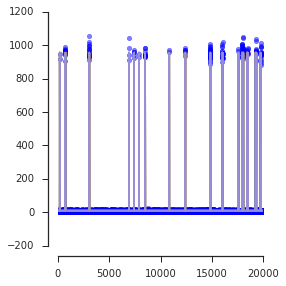

In [248]:
data1 = 'Wn_single.h5'
emission_data = pd.HDFStore(data1)
fig = plt.figure(figsize=(4,4)) 
    
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(4000,5000,100):
    plt.plot(range(N),emission_data['df{}'.format(i)].iloc[0]) 
plt.scatter(range(N), Wn, color="blue", alpha=0.5)
plt.xlim([0,20000])
# plt.ylim([0,3000])
# plt.ylabel(ylabel)
# plt.xlabel(xlabel)
plt.tight_layout()
sns.despine(offset=10)
# fig.savefig('Emission_distribution.pdf')

In [228]:
step = 0.01
partitions = [i*step for i in range(round(200./step))]
t = partitions

In [229]:
np.shape(Sn_true[0,:])

(19999,)

In [230]:
np.shape(t[:-1])

(19999,)

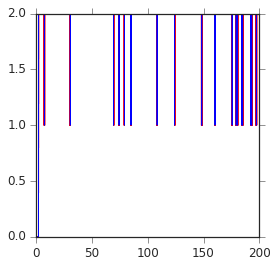

In [232]:
Sn_true = pd.read_csv('trajectory_single_particle.csv').drop('Unnamed: 0',axis=1).values

data3 = 'trajectory_single.h5'
traj = pd.HDFStore(data3)
fig = plt.figure(figsize=(4,4)) 
    
plt.style.use('ggplot')
sns.set_style('ticks')
plt.rcParams['font.size'] = 12
for i in range(2400,5000,100):
    plt.step(x=t[:-1],y=traj['df{}'.format(i)].iloc[0],color='red') 
plt.step(x=t[:-1],y=Sn_true[0,:], color="blue") 

In [233]:
df = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in out[0].items()]))

(0, 25)

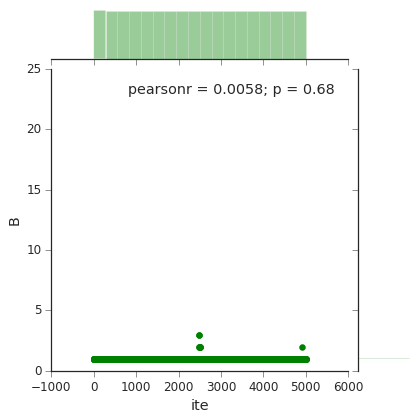

In [234]:
h = sns.jointplot(x=df['ite'],y=df['B'], kind='scatter',color='g',s =20,linewidth=2)
h.ax_joint.set_ylim([0,25])

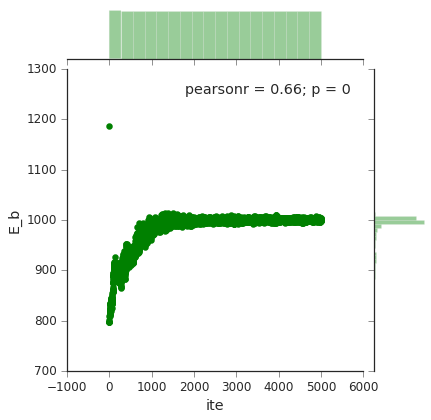

In [235]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_b'], kind='scatter',color='g',s =20,linewidth=2)
sns.set(style="darkgrid", color_codes=False)
# sns_plot.savefig('Emission_background.pdf')

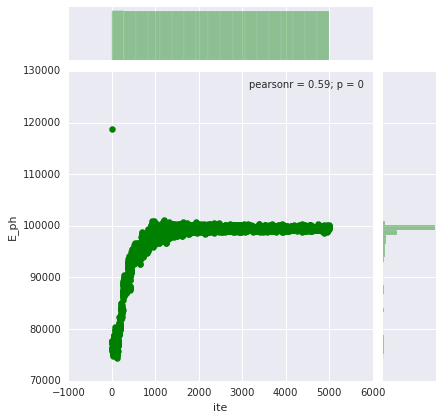

In [236]:
sns_plot = sns.jointplot(x=df['ite'],y=df['E_ph'], kind='scatter',color='g',s =20,linewidth=2)
# sns_plot.ax_joint.set_ylim([0,5000])
sns_plot.savefig('Photon_Emission.pdf')

In [237]:
d = (scipy.special.kv(hyper_param['alfa']-hyper_param['alfa1_prior'],2*np.sqrt(np.linspace(1,40,1000))*(hyper_param['beta1']*hyper_param['beta2']))/
     np.linspace(1,40,1000)**(1-(hyper_param['alfa']+hyper_param['alfa1_prior'])/2))

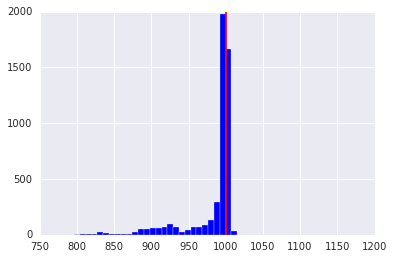

In [243]:
n, bins, patches = plt.hist(out[0]['E_b'], 50, facecolor='blue')
# plt.plot(d*10000,color='k')
# plt.xlim([0,40])
# plt.ylim([0,1])
plt.axvline(1000, color='r')

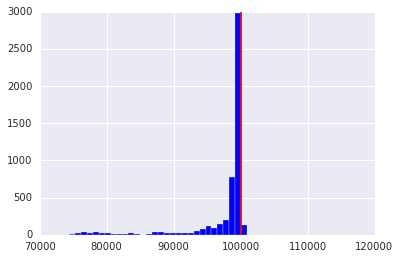

In [241]:
n, bins, patches = plt.hist(out[0]['E_ph'], 50, facecolor='blue')
plt.axvline(1e+5, color='r')

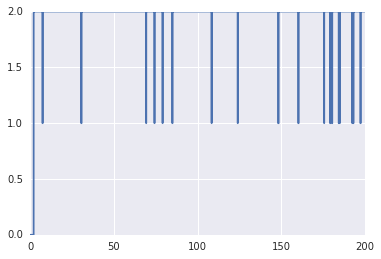

In [240]:
plt.step(x=t[:-1],y=Sn[0,:])

In [244]:
out1 = out[2] 
pi_true = np.array([[9.95012479e-01, 4.72285706e-03, 2.40596046e-04, 2.40677016e-05],
                    [0.00000000e+00, 8.95880600e-01, 9.46496180e-02, 9.46978182e-03],
                    [0.00000000e+00, 9.46496180e-04, 9.99048684e-01, 4.82001787e-06],
                    [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = dict([(index,0) for index,v in np.ndenumerate(pi)])
for index, x in np.ndenumerate(pi):
    i = index[0]
    j = index[1]
    d[index] = list(out1.iloc[i::4,j])
    
def plot_hist(dic, pi_true):
    fig = plt.figure(figsize=(16,16)) 
    plt.style.use('ggplot')
    sns.set_style('ticks')
    plt.rcParams['font.size'] = 12

    nn = 1
    for i, x in np.ndenumerate(pi_true):
        ax = fig.add_subplot(4,4,nn)
        n, bins, patches = plt.hist(dic[i], 10, facecolor='blue')
        plt.axvline(pi_true[i], color='r')
#         ax.set_title(r'$particle-ID: {}$'.format(str(i)))
#         ax.legend().set_visible(False)
        sns.despine(offset=12,ax=ax,trim=True)
        nn = nn+1

    # plt.subplots_adjust(top=0.92,bottom=0.08,left=0.1,right=0.95,wspace=0.6,hspace=0.6)
    plt.tight_layout()
    plt.show() 
    fig.savefig('Probability_distribution.pdf')
    return None

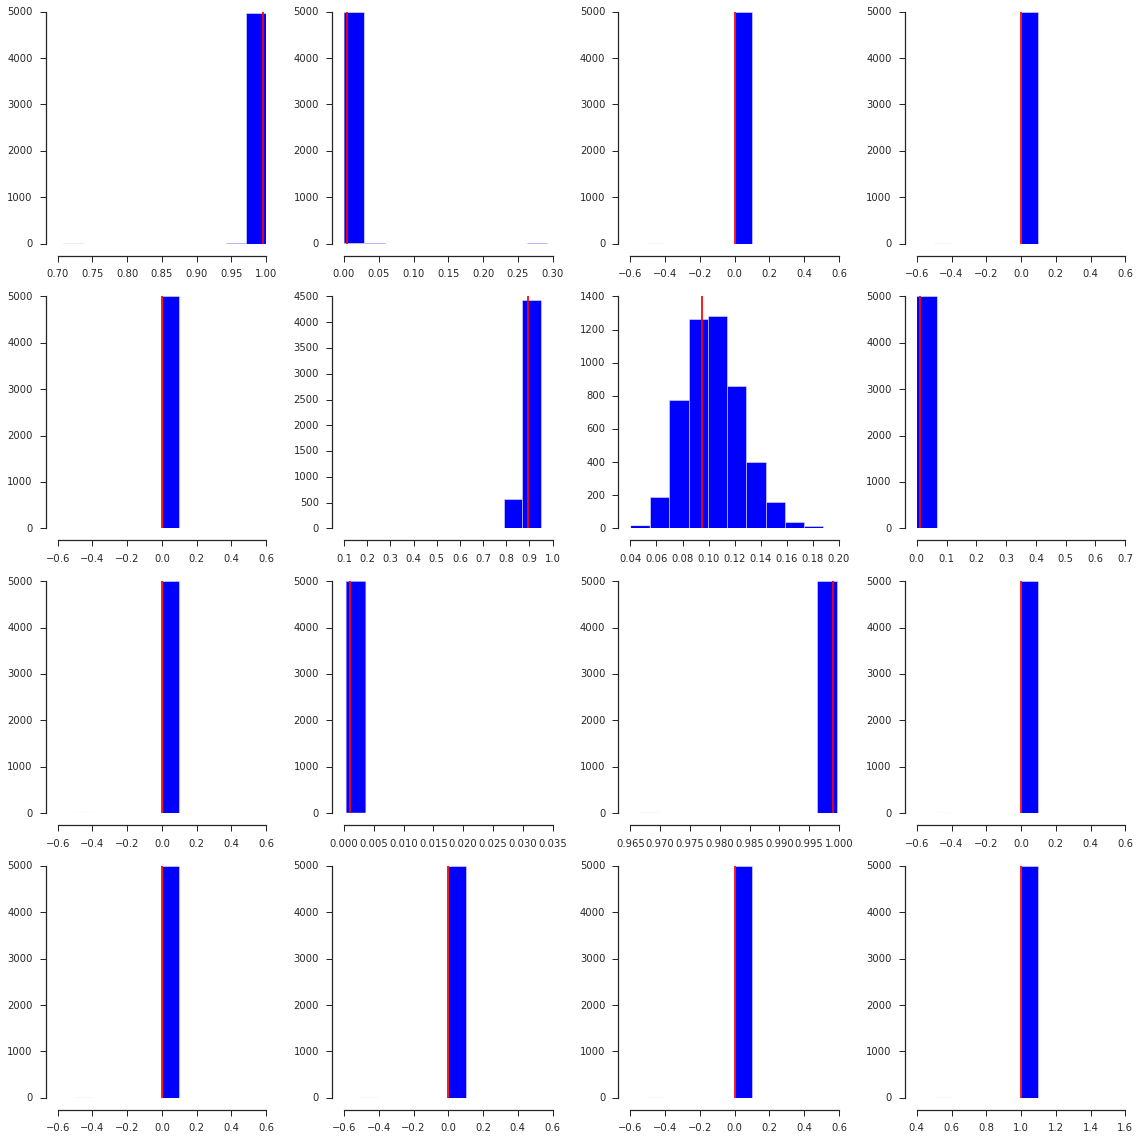

In [245]:
plot_hist(d, pi_true)